# Database Spotify
## Itegrantes: Isabella Abreu Comelli - 10400807, Pedro Henrique Wege Barbosa - 10400851

Link do Colab:

https://colab.research.google.com/drive/1rr6noxzXdB7f6xwbzzrvlD5WYVw7TArR?usp=sharing

Arquivos disponíveis em:

https://drive.google.com/drive/folders/1St9-2VWKUYEUl1uBNAFSOhRMD8C9zXLp?usp=sharing

Link para a criação das client keys para se conectar à API do Spotify (é necessário ter uma conta na plataforma):

https://developer.spotify.com/dashboard/create

Caso não queira fazer a conexão com a API do Spotify:
- Salve os arquivos em 'Arquivos';
- Rode o código as etapas 'Configs', 'Functions';
- Pule para a etapa 'Dataframe Principal' e rode a partir dela.

# Configs

In [ ]:
pip install dtreeviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.9 MB/s eta 0:00:00


In [ ]:
from google.colab import userdata
import base64
import requests
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
from google.colab import drive
import os
from sklearn import tree
import graphviz
import dtreeviz.trees
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

drive.mount('/content/drive')
data_path = ('/content/drive/My Drive/spotify_data' if 'drive' in os.listdir() else '')

client_id = userdata.get('client_id')
client_secret = userdata.get('client_secret')

Mounted at /content/drive


# Functions

In [ ]:
def get_token(client_id, client_secret):
    """
    Obtém um token de acesso à API do Spotify usando credenciais de cliente e verifica seu tipo de token.

    Args:
        client_id (str): Chave ID do cliente da API do Spotify.
        client_secret (str): Chave Segredo do cliente da API do Spotify.

    Returns:
        str: Código de acesso obtido da API do Spotify.
        str: Tipo de token do código de acesso (ou None se falhar ao recuperar).
        str: Tempo de disponibilidade do token em segundos.
    """
    base64_auth = base64.b64encode(f"{client_id}:{client_secret}".encode()).decode()

    auth_options = {
        'url': 'https://accounts.spotify.com/api/token',
        'headers': {
            'Authorization': 'Basic ' + base64_auth,
            'Content-Type' : 'application/x-www-form-urlencoded'
        },
        'data': {
            'grant_type': 'client_credentials'
        }
    }

    response = requests.post(auth_options['url'], headers=auth_options['headers'], data=auth_options['data'])

    if response.status_code == 200:
        r = response.json()
        token = r['access_token']
        token_type = r['token_type']
        token_duration = r['expires_in']
        print(f'Token de Acesso requisitado com successo!')
        print(f'Tipo do Token: {token_type}')
        print(f'Disponibilidade do Token: {token_duration} segundos')
    else:
        print('Não foi possível obter o token de acesso')

    return f'{token_type} {token}'


def api_call(url, access_token):
    """
    Chama a API do Spotify usando um endpoint de URL e um token de acesso para recuperar dados no formato JSON.

    Args:
        url (str): Endpoint de URL para acessar dados de faixas disponíveis.
            URL padrão fornecida - SPOTIFY_URL/search?q=genre:{genre}&type=track&market={market}&limit={limit}&offset={offset}

        access_token (str): Token de acesso à API do Spotify fornecido com o uso da função get_token.

    Returns:
        dict: Objeto JSON com a resposta da API.
    """
    response = requests.get(url, headers={'Authorization': access_token})
    api_response = response.json()

    return api_response


def check_new_spotify_genres():
  dict_genres = {**dict_main_genres, **{i: None for i in list_disposable_genres}}
  list_new_spotify_genres = [i for i in list_spotify_genres if i not in dict_genres.keys()]

  if list_new_spotify_genres:
    return list_new_spotify_genres


def format_main_genre(genre_list):
  # 1- acoustic e len > 1 = remove
  # 2- mpb e len > 1 = remove
  # 3- classical, opera = opera
  #    electronic, house = house
  #    electronic, techno = techno
  #    alternative, rock = alternative
  #    metal, rock = metal
  # 4- alt-pop = alternative, pop

  for i in ['acoustic', 'mpb']:
    if len(genre_list) > 1 and i in genre_list:
      genre_list.remove(i)

  for key, value in dict_replace_main_genres.items():
    key = key.split(', ')

    if all(k in genre_list for k in key):
      for k in key:
        if k in genre_list:
          genre_list.remove(k)

      genre_list.extend(value)

    genre_list = sorted(list(set(genre_list)))

  return ', '.join(genre_list)


def get_top_tracks(dict_genres, pages):
  df = pd.DataFrame()
  limit = 50

  for i, genre in enumerate(dict_genres.keys()):
    for offset in range(0, (pages * limit), limit):
      if not offset:
        print(f"Processando dados de '{genre}' [{i+1}/{len(dict_genres)}]")

      url = f'{SPOTIFY_URL}/search?q=genre:{genre}&type=track&market=BR&limit={str(limit)}&offset={offset}'
      json = api_call(url, client_token)

      data = [
        {
          'track_id': track['id']
          ,'track_name': track['name']
          ,'track_popularity': track['popularity']
          ,'track_duration_ms': track['duration_ms']
          ,'track_explicit': track['explicit']
          ,'track_genre': genre
          ,'artist_id': ', '.join([artist['id'] for artist in track['artists']])
          ,'artist_name': ', '.join([artist['name'] for artist in track['artists']])
          ,'album_id': track['album']['id']
          ,'album_name': track['album']['name']
          ,'album_type': track['album']['album_type']
          ,'album_release_date': track['album']['release_date']
          ,'album_total_tracks': track['album']['total_tracks']
          ,'album_track_number': track['track_number']
        }
        for track in json['tracks']['items']
      ]

      df_tracks = pd.DataFrame(data)
      df = pd.concat([df, df_tracks])

  # Transformando track_explicit de boolean para int
  df['track_explicit'] = np.where(df['track_explicit'], 1, 0)

  # Enfileirando track_genre
  sup_track_genre_n = df[['track_id', 'track_genre']].drop_duplicates().sort_values(by='track_genre')

  sup_track_genre_n['genre_num'] = sup_track_genre_n.groupby('track_id').cumcount() + 1

  sup_track_genre_n = sup_track_genre_n.set_index(['track_id', 'genre_num'])['track_genre'].unstack()
  sup_track_genre_n.columns = [f'track_genre_{i}' for i in sup_track_genre_n.columns]

  df = df.join(sup_track_genre_n, on='track_id')

  # Definindo track_main_genre
  sup_track_main_genre = df.copy()

  sup_track_main_genre['track_main_genre'] = sup_track_main_genre['track_genre'].map(dict_main_genres)
  sup_track_main_genre = sup_track_main_genre[['track_id', 'track_main_genre']].drop_duplicates()

  sup_track_main_genre = sup_track_main_genre.groupby('track_id')['track_main_genre'].apply(lambda x: format_main_genre(list(x.dropna())))

  df = df.join(sup_track_main_genre, on='track_id')

  # Filtrando e organizando o df
  sort_df = ['track_id', 'track_name', 'track_popularity', 'track_duration_ms', 'track_explicit', 'track_main_genre']\
    + [i for i in df if 'track_genre_' in i]\
    + ['artist_id', 'artist_name', 'album_id', 'album_name', 'album_type', 'album_release_date', 'album_total_tracks', 'album_track_number']

  df = df[sort_df].drop_duplicates()\
                  .sort_values(by='track_popularity', ascending=False)\
                  .reset_index(drop=True)

  print('Finalizado!')
  return df


def get_tracks_audio_features(df_tracks):
  df = pd.DataFrame()
  num_tracks = df_tracks.shape[0]
  limit = 100

  for i in range(0, num_tracks, limit):
    if num_tracks < 5000 and i == 0:
      print('Processando..')
    elif i % 5000 == 0 and i != 0:
        print(f"Processando [{i}/{num_tracks}]")

    ids = ','.join(df_tracks[i:(i + limit)].track_id.to_list())
    url = f'{SPOTIFY_URL}/audio-features?ids={ids}'
    json = api_call(url, client_token)

    data = [
      {
        'track_id': track['id']
        ,'track_danceability': track['danceability']
        ,'track_energy': track['energy']
        ,'track_key': track['key']
        ,'track_loudness': track['loudness']
        ,'track_mode': track['mode']
        ,'track_speechiness': track['speechiness']
        ,'track_acousticness': track['acousticness']
        ,'track_instrumentalness': track['instrumentalness']
        ,'track_liveness': track['liveness']
        ,'track_valence': track['valence']
        ,'track_tempo': track['tempo']
        ,'track_time_signature': track['time_signature']
      }
      for track in json['audio_features']
    ]

    df_audio_features = pd.DataFrame(data)
    df = pd.concat([df, df_audio_features])

  print('Finalizado!')
  return df


def fix_exponential(s):
  if re.match(r'^[0-9.]+e-$', s):
    return s + '1'
  return s


def categorizar_colunas(df, colunas, categorias, tipo_labels, min_cols=None, max_cols=None):
  if isinstance(colunas, str):
    colunas = [colunas]

  for coluna in colunas:
    min = (df[coluna].min() if min_cols == None else min_cols)
    max = (df[coluna].max() if max_cols == None else max_cols)
    bins = np.linspace(min, max, categorias+1)

    if tipo_labels == 'ABC':
      labels = [chr(65 + i) for i in range(categorias)]
    elif tipo_labels == '123':
      labels = [i+1 for i in range(categorias)]
    elif tipo_labels == '012':
      labels = [i for i in range(categorias)]
    else:
      labels = [f'<= {round(bins[i+1], 2)}' for i in range(categorias)]  # <= 0.25, <= 0.5...
      print(bins)

    # print(labels)
    df[f'{coluna}_categoria'] = pd.cut(df[coluna], bins=bins, labels=labels, include_lowest=True)

  return df


def train_test_model(model, kf):
  cm_plots = []
  acuracias = []

  for fold_index, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()

    if model == 'KNN':
      model = KNeighborsClassifier(n_neighbors=5)
    elif model == 'DT':
      model = tree.DecisionTreeClassifier(criterion='entropy')

    fit = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm)
    acuracia = cm.diagonal().sum() / cm.sum()
    cm_plots.append(cm_plot)
    acuracias.append(acuracia)

  return fit, cm_plots, acuracias

# Variables

In [ ]:
client_token = get_token(client_id, client_secret)

SPOTIFY_URL = 'https://api.spotify.com/v1'

Token de Acesso requisitado com successo!
Tipo do Token: Bearer
Disponibilidade do Token: 3600 segundos


In [ ]:
list_spotify_genres = api_call(f'{SPOTIFY_URL}/recommendations/available-genre-seeds', client_token)['genres']

# Obs: os gêneros 'bossanova', 'metal-misc' e 'post-dubstep' não retornam itens na função get_top_tracks
dict_main_genres = {
  'acoustic': ['acoustic', 'bluegrass', 'folk', 'guitar', 'new-age', 'piano'],
  'rock': ['emo', 'goth', 'hard-rock', 'hardcore', 'j-rock', 'power-pop', 'psych-rock', 'punk', 'punk-rock', 'rock', 'rock-n-roll', 'rockabilly', 'ska'],
  'alternative': ['alternative', 'alt-rock', 'garage', 'grunge', 'indie', 'trip-hop'],
  'metal': ['black-metal', 'death-metal', 'grindcore', 'heavy-metal', 'metal', 'metalcore', 'metal-misc'],
  'electronic': ['breakbeat', 'drum-and-bass', 'dubstep', 'edm', 'electro', 'electronic', 'hardstyle', 'idm', 'industrial', 'post-dubstep', 'trance'],
  'house': ['dance', 'j-dance', 'disco', 'chicago-house', 'club', 'deep-house', 'house', 'progressive-house'],
  'techno': ['detroit-techno', 'minimal-techno', 'techno'],
  'pop': ['cantopop', 'j-idol', 'j-pop', 'k-pop', 'mandopop', 'pop', 'pop-film', 'reggaeton', 'synth-pop'],
  'alt-pop': ['indie-pop'],
  'rnb': ['r-n-b'],
  'jazz': ['blues', 'jazz', 'soul'],
  'country': ['country', 'honky-tonk'],
  'classical': ['classical'],
  'forro': ['forro'],
  'funk': ['funk'],
  'gospel': ['gospel'],
  'hip-hop': ['hip-hop'],
  'mpb': ['bossanova', 'mpb'],
  'opera': ['opera'],
  'pagode': ['pagode'],
  'reggae': ['dancehall', 'dub', 'reggae'],
  'salsa': ['salsa'],
  'samba': ['samba'],
  'sertanejo': ['sertanejo'],
  'tango': ['tango'],
}

dict_main_genres = {main: genre for genre, mains in dict_main_genres.items() for main in mains}

list_disposable_genres = ['ambient', 'anime', 'children', 'chill', 'comedy',
  'disney', 'groove', 'happy', 'holidays', 'kids',
  'movies', 'new-release', 'party', 'rainy-day', 'road-trip',
  'romance', 'sad', 'show-tunes', 'singer-songwriter', 'sleep',
  'songwriter', 'soundtracks', 'study', 'summer', 'work-out',
  'afrobeat', 'brazil', 'british', 'french', 'german',
  'indian', 'iranian', 'latin', 'latino', 'malay',
  'philippines-opm', 'spanish', 'swedish', 'turkish', 'world-music'] ########## groove

dict_replace_main_genres = {
    'alt-pop': ['alternative', 'pop'],
    'classical, opera': ['opera'],
    'electronic, house': ['house'],
    'electronic, techno': ['techno'],
    'alternative, rock': ['alternative'],
    'metal, rock': ['metal'],
}

In [ ]:
check_new_spotify_genres()

# Tracks
Lendo e atualizando os dados de df_tracks. Caso a API apresente algum problema, será utilizado o último arquivo csv salvo.

In [ ]:
pages = 2 # * 5 = 100

try:
  df_tracks = get_top_tracks(dict_main_genres, pages)
  df_tracks.to_csv(f'{data_path}/df_tracks.csv', index=False, sep=';')
  print("Arquivo 'df_tracks.csv' atualizado.")
except KeyError:
  print('KeyError. Utilizando df_tracks exportado do arquivo csv.')
  df_tracks = pd.read_csv(f'{data_path}/df_tracks.csv', sep=';', low_memory=False)

Processando dados de 'acoustic' [1/86]
Processando dados de 'bluegrass' [2/86]
Processando dados de 'folk' [3/86]
Processando dados de 'guitar' [4/86]
Processando dados de 'new-age' [5/86]
Processando dados de 'piano' [6/86]
Processando dados de 'emo' [7/86]
Processando dados de 'goth' [8/86]
Processando dados de 'hard-rock' [9/86]
Processando dados de 'hardcore' [10/86]
Processando dados de 'j-rock' [11/86]
Processando dados de 'power-pop' [12/86]
Processando dados de 'psych-rock' [13/86]
Processando dados de 'punk' [14/86]
Processando dados de 'punk-rock' [15/86]
Processando dados de 'rock' [16/86]
Processando dados de 'rock-n-roll' [17/86]
Processando dados de 'rockabilly' [18/86]
Processando dados de 'ska' [19/86]
Processando dados de 'alternative' [20/86]
Processando dados de 'alt-rock' [21/86]
Processando dados de 'garage' [22/86]
Processando dados de 'grunge' [23/86]
Processando dados de 'indie' [24/86]
Processando dados de 'trip-hop' [25/86]
Processando dados de 'black-metal' [

# Audio Features
Lendo e atualizando os dados de df_audio_features. Caso df_tracks não possua novas músicas ou a API apresente algum problema, será utilizado o último arquivo csv salvo.

In [ ]:
df_audio_features_old = pd.read_csv(f'{data_path}/df_audio_features.csv', sep=';', low_memory=False)
df_audio_features = df_audio_features_old.copy()

df_tracks_filtrado = df_tracks.query("track_id not in @df_audio_features_old.track_id.to_list()")

if df_tracks_filtrado.shape[0]:
  try:
    # Se a chamada na API for bem sucedida, df_audio_features será substituído pelo novo
    df_audio_features = get_tracks_audio_features(df_tracks_filtrado)
    df_audio_features = pd.concat([df_audio_features_old, df_audio_features]).drop_duplicates()
    df_audio_features.to_csv(f'{data_path}/df_audio_features.csv', index=False, sep=';')
    print("Arquivo 'df_audio_features.csv' atualizado.")
  except KeyError:
    print('KeyError. Utilizando df_audio_features exportado do arquivo csv.')
else:
    print('df_tracks não possui atualizações. Utilizando df_audio_features exportado do arquivo csv.')

Processando..
Finalizado!
Arquivo 'df_audio_features.csv' atualizado.


# Dataframe Principal
Formando dataframe principal a partir da junção de df_tracks e df_audio_features e formatando antes dos levantamentos.

Para o projeto de Ciência de Dados, algumas colunas referentes às características de áudio e outras descartáveis serão desconsideradas:
* track_mode
* track_energy
* track_acousticness
* track_liveness
* track_valence
* track_loudness
* track_time_signature
* track_genre_n (subgêneros)
* album_id
* album_name
* album_type
* album_release_date
* album_total_tracks
* album_track_number


In [ ]:
# Leitura manual
df_tracks = pd.read_csv(f'{data_path}/df_tracks.csv', sep=';', low_memory=False)
df_audio_features = pd.read_csv(f'{data_path}/df_audio_features.csv', sep=';', low_memory=False)

In [ ]:
df = df_tracks.join(df_audio_features.set_index('track_id'), on='track_id')

In [ ]:
df[df.select_dtypes(include=['int64', 'float64']).columns] = df.select_dtypes(include=['int64', 'float64']).fillna(0)
df['track_instrumentalness'] = pd.to_numeric(df['track_instrumentalness'].astype('str').apply(fix_exponential))
# df['track_time_signature'] = df['track_time_signature'].astype('int64')

df['track_main_genre_id'] = pd.factorize(df['track_main_genre'])[0]

df = df.filter(regex='^(?!.*album).*$')\
       .filter(regex='^(?!.*track_genre).*$')\
       .drop(columns=['track_mode', 'track_energy', 'track_acousticness', 'track_liveness', 'track_valence', 'track_loudness', 'track_time_signature'])\
       .head(100)

# Categorizando colunas
cols_1 = ['track_danceability', 'track_speechiness', 'track_instrumentalness'] # vão de 0 a 1
cols_2 = ['track_tempo'] # outros ranges
cols_3 = ['track_key'] # já são categóricos

df = categorizar_colunas(df, cols_1, categorias=2, tipo_labels='012', min_cols=0, max_cols=1)
df = categorizar_colunas(df, cols_2, categorias=2, tipo_labels='012')
df = categorizar_colunas(df, 'track_popularity', categorias=10, tipo_labels='012', min_cols=0, max_cols=100)
df[f'{cols_3[0]}_categoria'] = df[cols_3[0]]

df[df.filter(like='categoria').columns] = df.filter(like='categoria')\
                                            .astype('int64')

## Estatísticas

Info

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   track_id                          100 non-null    object 
 1   track_name                        100 non-null    object 
 2   track_popularity                  100 non-null    int64  
 3   track_duration_ms                 100 non-null    int64  
 4   track_explicit                    100 non-null    int64  
 5   track_main_genre                  100 non-null    object 
 6   artist_id                         100 non-null    object 
 7   artist_name                       100 non-null    object 
 8   track_danceability                100 non-null    float64
 9   track_key                         100 non-null    int64  
 10  track_speechiness                 100 non-null    float64
 11  track_instrumentalness            100 non-null    float64
 12  track_tem

Estatísticas Descritivas

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
track_popularity,100.0,87.060000,2.863282,84.0000,85.00000,86.500000,88.000000,100.000
track_duration_ms,100.0,206238.100000,45337.655786,86983.0000,173456.75000,204313.000000,239203.750000,356066.000
track_explicit,100.0,0.210000,0.409360,0.0000,0.00000,0.000000,0.000000,1.000
track_danceability,100.0,0.615900,0.144811,0.2640,0.50725,0.612000,0.719250,0.924
track_key,100.0,5.610000,3.617843,0.0000,2.00000,6.000000,9.000000,11.000
track_speechiness,100.0,0.063086,0.054381,0.0256,0.03425,0.044150,0.063375,0.276
track_instrumentalness,100.0,0.032188,0.128693,0.0000,0.00000,0.000005,0.000461,0.879
track_tempo,100.0,121.819320,29.494032,67.5280,101.50575,117.056500,139.986250,186.003
track_main_genre_id,100.0,4.050000,3.798923,0.0000,1.00000,2.000000,6.000000,15.000
track_danceability_categoria,100.0,0.770000,0.422953,0.0000,1.00000,1.000000,1.000000,1.000


Matriz de Correlação entre as características de áudio e a popularidade

In [ ]:
corr = df[['track_popularity'] + cols_1 + cols_2 + cols_3].corr()
corr.style.background_gradient(cmap='cividis')

,track_popularity,track_danceability,track_speechiness,track_instrumentalness,track_tempo,track_key
track_popularity,1.000000,0.058092,-0.135745,-0.015121,0.079505,-0.011370
track_danceability,0.058092,1.000000,0.224276,-0.151371,-0.195436,-0.029458
track_speechiness,-0.135745,0.224276,1.000000,-0.095401,0.047298,0.092207
track_instrumentalness,-0.015121,-0.151371,-0.095401,1.000000,0.061112,0.113385
track_tempo,0.079505,-0.195436,0.047298,0.061112,1.000000,0.232094
track_key,-0.011370,-0.029458,0.092207,0.113385,0.232094,1.000000


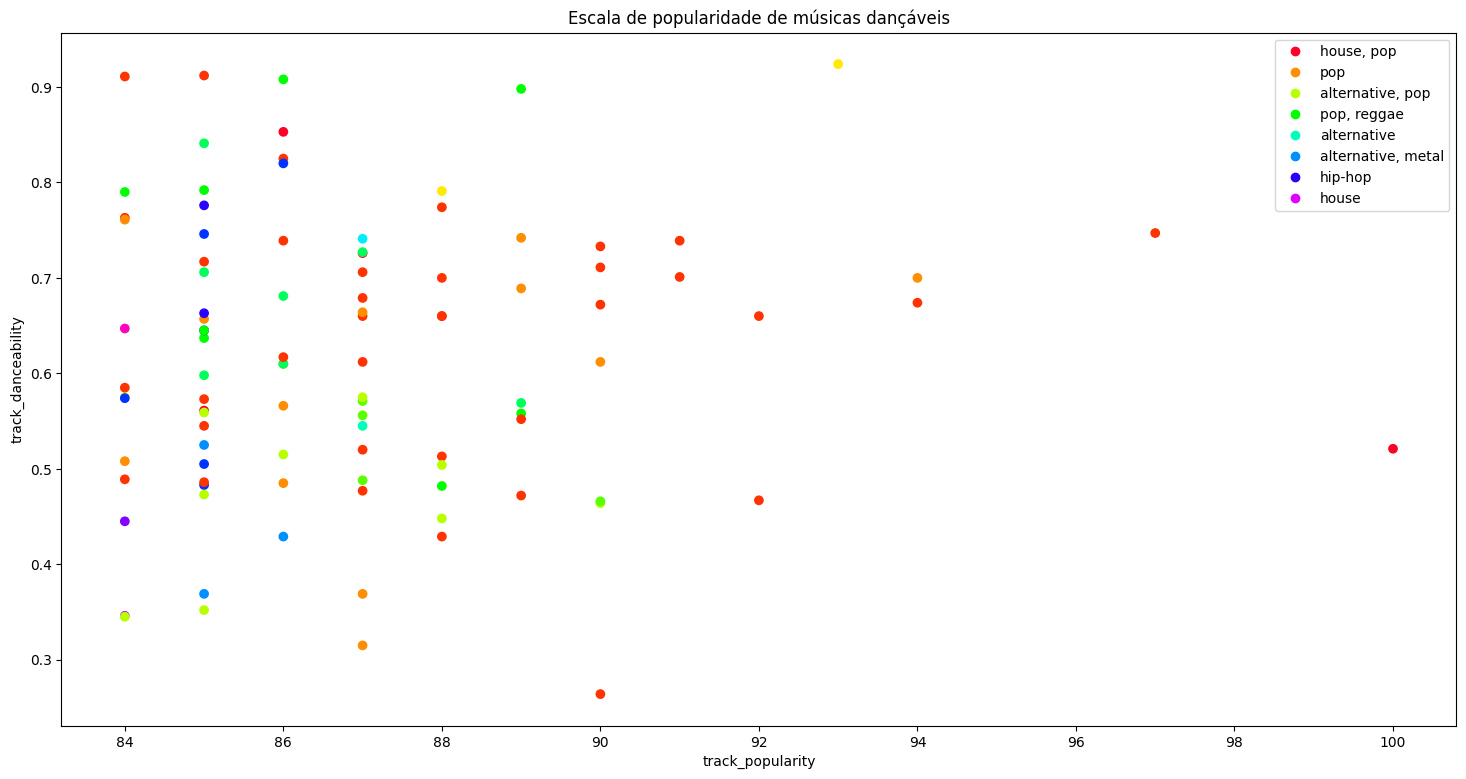

In [ ]:
plt.figure(figsize=(18, 9))
grafico = plt.scatter(df['track_popularity'], df['track_danceability'], c=df['track_main_genre_id'], cmap='gist_rainbow')
plt.title('Escala de popularidade de músicas dançáveis')
plt.xlabel('track_popularity')
plt.ylabel('track_danceability')
# plt.xlim(df['track_popularity'].min() - 10, df['track_popularity'].max() + 10)
plt.legend(grafico.legend_elements(prop='colors')[0], df['track_main_genre'].unique())
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x7be05c3c5330>,
 'caps': [<matplotlib.lines.Line2D at 0x7be05c3c4f10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7be05c3c55d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7be05c3c49d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7be05c3c4730>],
 'means': []}

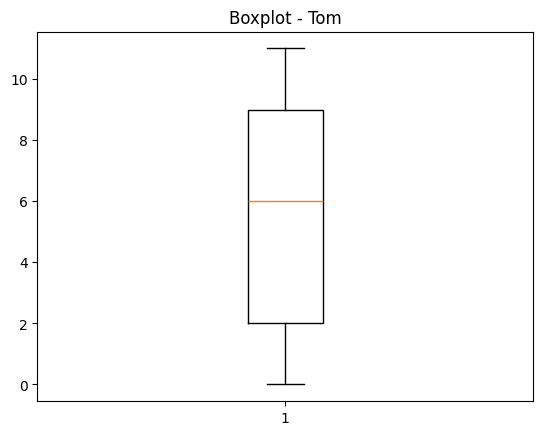

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Boxplot - Tom')
ax.boxplot(df['track_key'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7be05c3b89d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7be05c3b8490>,
 'boxes': [<matplotlib.lines.Line2D at 0x7be05c3b8c70>],
 'medians': [<matplotlib.lines.Line2D at 0x7be05e46f8b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7be05e46fb50>],
 'means': []}

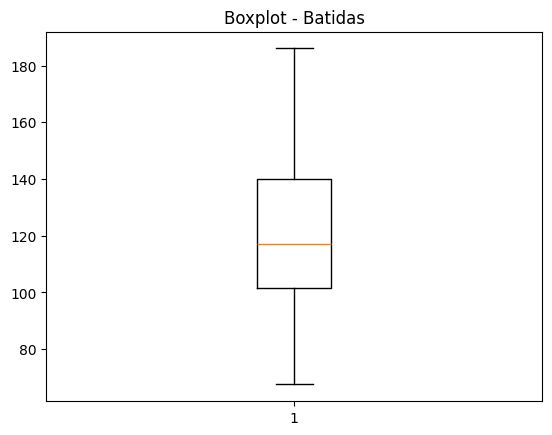

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Boxplot - Batidas')
ax.boxplot(df['track_tempo'])

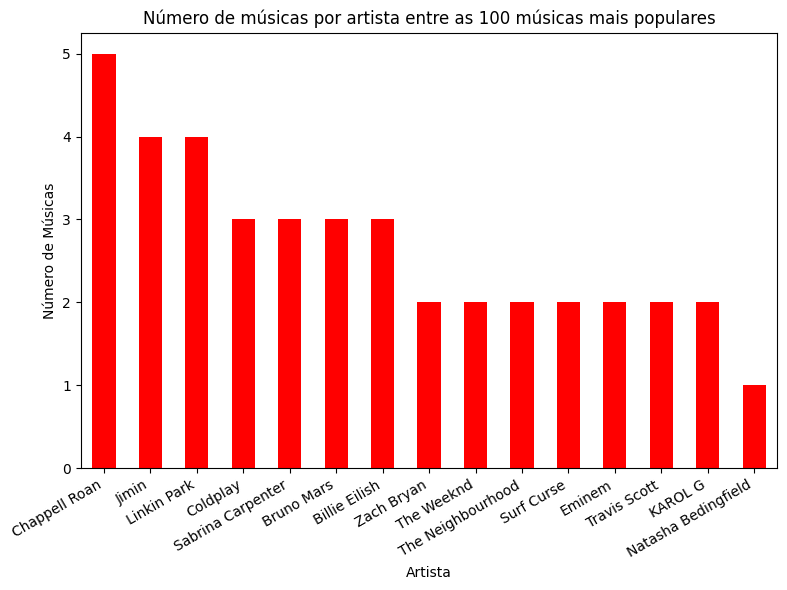

In [ ]:
df_barras_1 = df['artist_name'].value_counts()

plt.figure(figsize=(8, 6))
df_barras_1.head(15).plot(kind='bar', color='red')
plt.title('Número de músicas por artista entre as 100 músicas mais populares')
plt.xlabel('Artista')
plt.ylabel('Número de Músicas')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


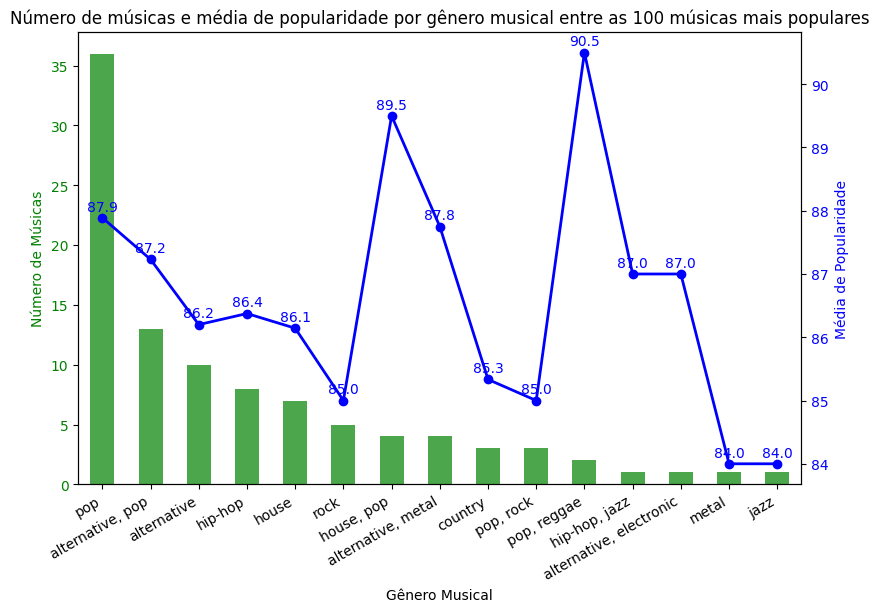

In [ ]:
df_barras_2 = df['track_main_genre'].value_counts()

media_popularidade = df.groupby('track_main_genre')['track_popularity'].mean()

fig, ax1 = plt.subplots(figsize=(8, 6))

df_barras_2.head(15).plot(kind='bar', color='green', alpha=0.7, ax=ax1)
ax1.set_xlabel('Gênero Musical')
ax1.set_ylabel('Número de Músicas', color='green')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()

ax1.tick_params(axis='y', labelcolor='green')
ax1.set_title('Número de músicas e média de popularidade por gênero musical entre as 100 músicas mais populares')

ax2 = ax1.twinx()

media_popularidade_head_15 = media_popularidade[df_barras_2.head(15).index]

ax2.plot(media_popularidade_head_15.index, media_popularidade_head_15.values, color='blue', marker='o', label='Média de Popularidade', linewidth=2)
ax2.set_ylabel('Média de Popularidade', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

for i, valor in enumerate(media_popularidade_head_15.values):
    ax2.annotate(f'{valor:.1f}', xy=(i, valor), xytext=(0, 5), textcoords='offset points', ha='center', color='blue')

plt.show()

# Modelos

In [ ]:
df_categoria = df.filter(like='categoria')

X = df_categoria.filter(regex='^(?!.*track_popularity).*$')
y = df_categoria.filter(like='track_popularity')

kf = KFold(n_splits=10)
kf_shuffle = KFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
knn_fit, knn_cm_plots, knn_acuracias = train_test_model(model='KNN', kf=kf)
dt_fit, dt_cm_plots, dt_acuracias = train_test_model(model='DT', kf=kf)
knn_shuffle_fit, knn_shuffle_cm_plots, knn_shuffle_acuracias = train_test_model(model='KNN', kf=kf_shuffle)
dt_shuffle_fit, dt_shuffle_cm_plots, dt_shuffle_acuracias = train_test_model(model='DT', kf=kf_shuffle)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
/usr

## Decision Tree

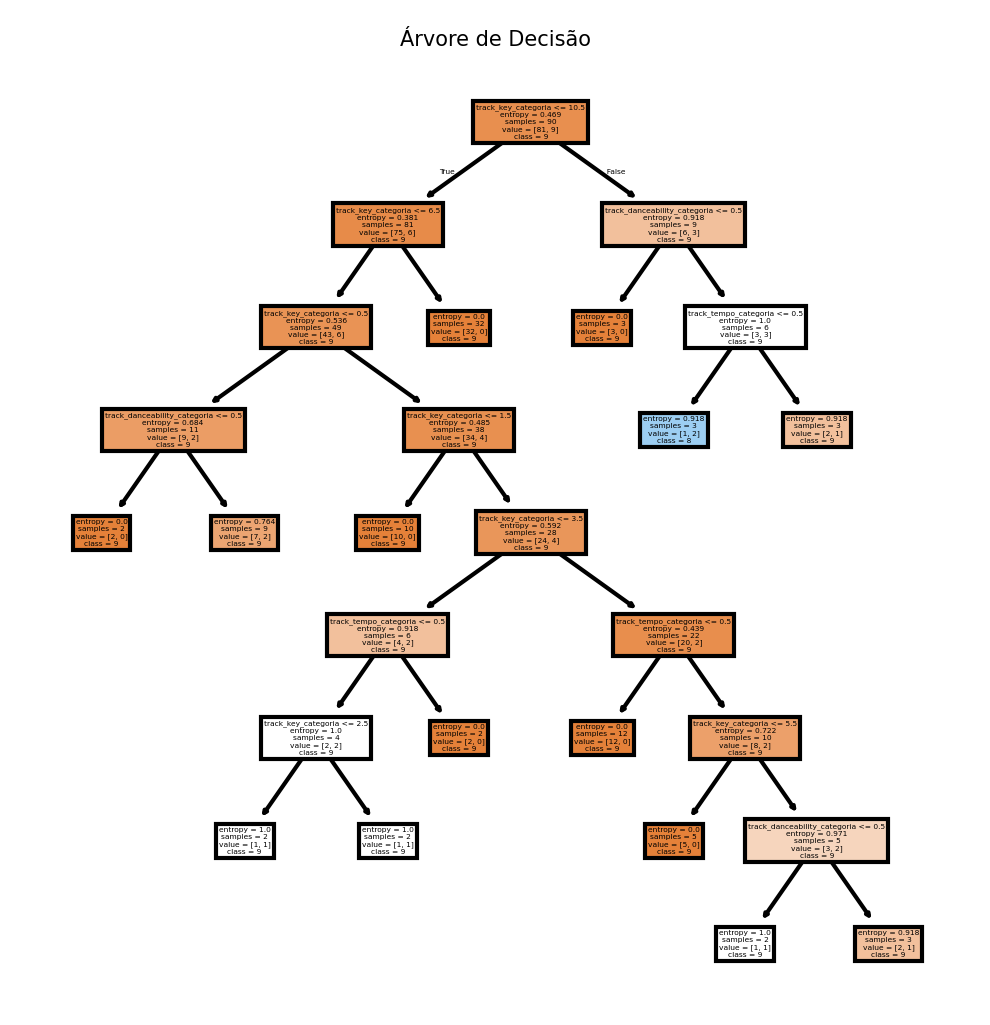

In [ ]:
fn=X.columns
cn=y['track_popularity_categoria'].astype('str').unique()

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=300)
tree.plot_tree(dt_fit,
               feature_names=fn,
               class_names=cn,
               filled=True)

plt.title('Árvore de Decisão', size=5)
plt.show()

## KNN - Confusion Matrix

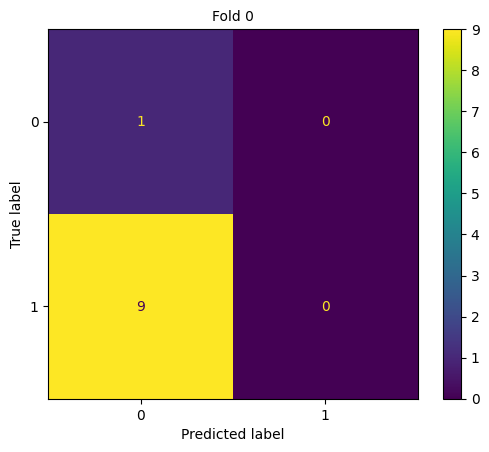

<Figure size 640x480 with 0 Axes>

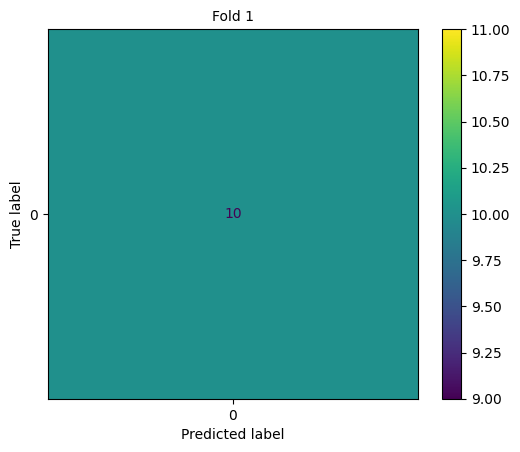

<Figure size 640x480 with 0 Axes>

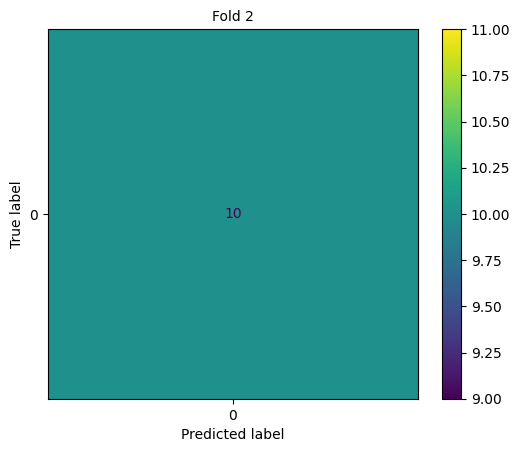

<Figure size 640x480 with 0 Axes>

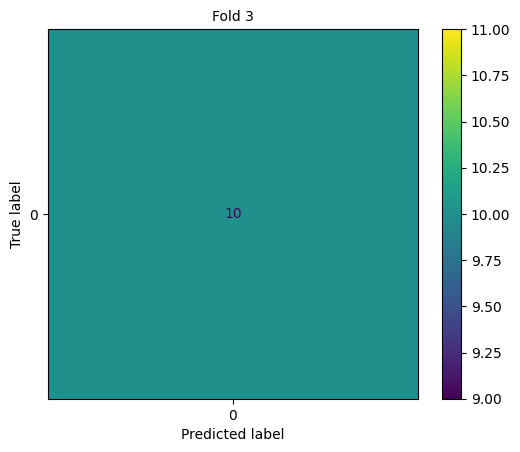

<Figure size 640x480 with 0 Axes>

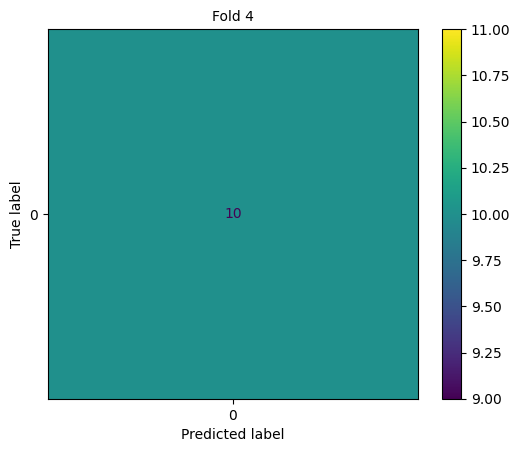

<Figure size 640x480 with 0 Axes>

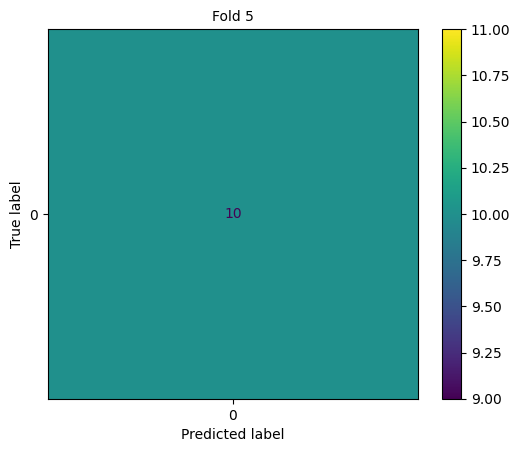

<Figure size 640x480 with 0 Axes>

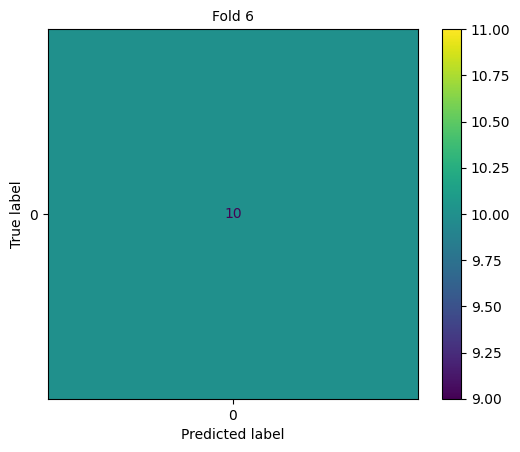

<Figure size 640x480 with 0 Axes>

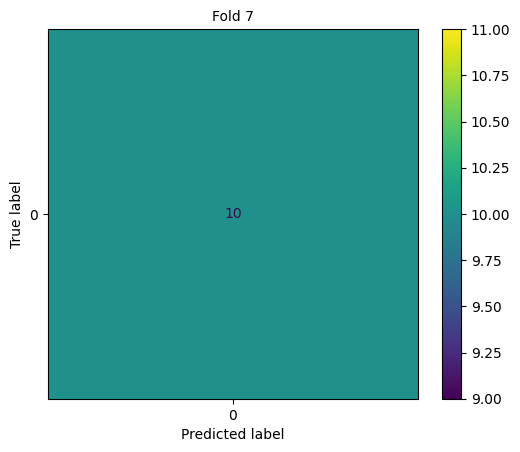

<Figure size 640x480 with 0 Axes>

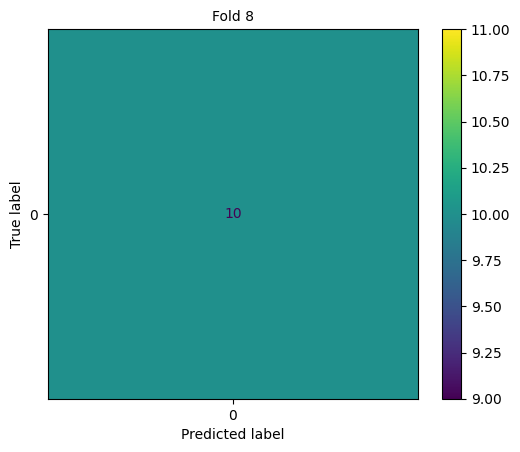

<Figure size 640x480 with 0 Axes>

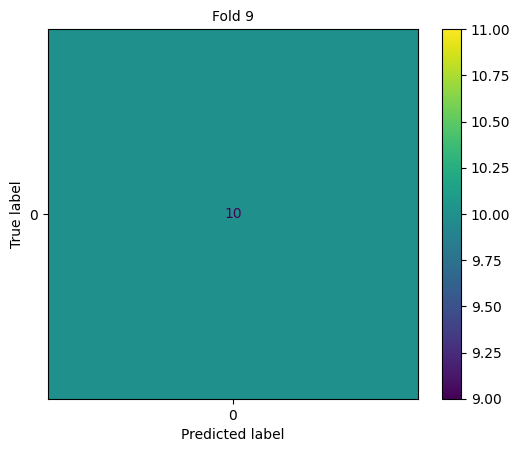

<Figure size 640x480 with 0 Axes>

In [ ]:
for i, cm in enumerate(knn_cm_plots):
  cm.plot()
  plt.title(f'Fold {i}', size=10)
  plt.show()
  plt.savefig(f'confusion_matrix_fold_{i}.png', bbox_inches='tight')

## Resultados dos Modelos

In [ ]:
print(f'{knn_acuracias=}')
print(f'média knn_acuracias={np.mean(knn_acuracias)}')
print(f'\n{dt_acuracias=}')
print(f'média dt_acuracias={np.mean(dt_acuracias)}')

print(f'\n\n{knn_shuffle_acuracias=}')
print(f'média knn_shuffle_acuracias={np.mean(knn_shuffle_acuracias)}')
print(f'\n{dt_shuffle_acuracias=}')
print(f'média dt_shuffle_acuracias={np.mean(dt_shuffle_acuracias)}')

knn_acuracias=[0.1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
média knn_acuracias=0.9099999999999999

dt_acuracias=[0.1, 0.9, 0.9, 1.0, 0.9, 1.0, 0.9, 1.0, 1.0, 0.9]
média dt_acuracias=0.86


knn_shuffle_acuracias=[0.9, 0.9, 1.0, 0.9, 0.9, 0.7, 1.0, 1.0, 0.8, 1.0]
média knn_shuffle_acuracias=0.9100000000000001

dt_shuffle_acuracias=[0.7, 0.9, 0.9, 0.9, 0.9, 0.7, 0.8, 0.9, 0.8, 1.0]
média dt_shuffle_acuracias=0.85


# KMeans

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

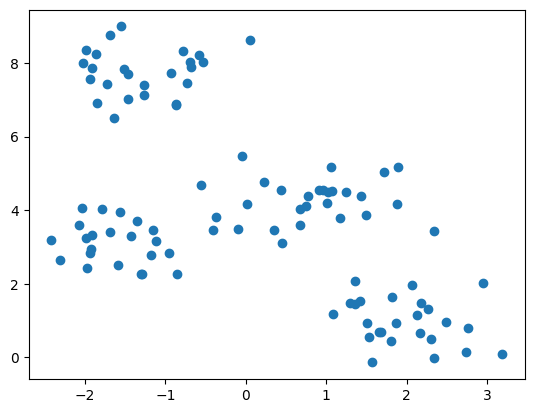

In [ ]:
X, y = make_blobs(n_samples=100, centers=4, cluster_std=0.60, random_state=0)


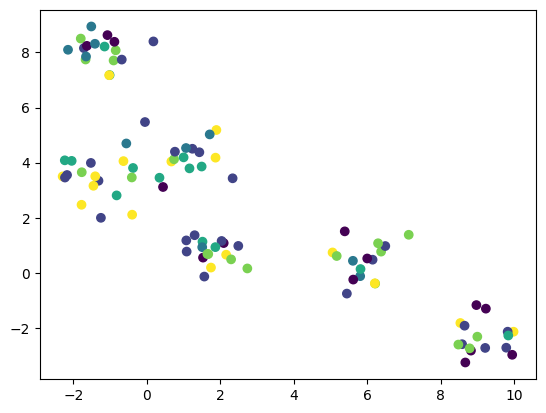

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(df_categoria)
X, y = make_blobs(n_samples=100, centers=4, cluster_std=0.60, random_state=0)

data_labels = kmeans.labels_
plt.scatter(X[:,0], X[:,1], c = data_labels, label=data_labels)

In [ ]:
print(data_labels)

[0 1 1 2 2 0 1 1 2 2 1 0 2 1 2 0 0 1 0 1 2 2 1 1 1 0 0 1 2 2 2 0 2 1 0 0 0
 2 0 0 0 1 0 1 2 2 2 2 2 1 1 1 0 1 0 2 0 1 0 1 0 2 2 1 0 1 1 2 0 0 0 0 2 0
 2 0 0 0 0 1 0 0 1 2 0 1 2 2 0 2 2 0 0 1 1 2 2 0 2 1]
